# Exploratory Analysis & Statistical Inference

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import stats # a script for statistical analysis and inference
import nlp # a script for preprocessing, exploring, and visualizing text
import cnn # helper functions for building cnn
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load the dataset as dataframe
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

# drop first column (index column in the csv file)
df = df.drop(df.columns[0], axis=1)

# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [3]:
# a copy of the original dataframe for statistical analysis
df_stats = df.copy()

# drop observations based on subsets
df_stats = df_stats.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'])

# create additional column on wordcount
df_stats['Word Count'] = df_stats['Review Text'].str.split().apply(len)

# sanity check
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 11 columns):
Clothing ID                22628 non-null int64
Age                        22628 non-null int64
Title                      19662 non-null object
Review Text                22628 non-null object
Rating                     22628 non-null int64
Recommended IND            22628 non-null int64
Positive Feedback Count    22628 non-null int64
Division Name              22628 non-null object
Department Name            22628 non-null object
Class Name                 22628 non-null object
Word Count                 22628 non-null int64
dtypes: int64(6), object(5)
memory usage: 2.1+ MB


In [4]:
# a statistical summary of the dataset
df_stats.describe().drop(['Clothing ID', 'Recommended IND'], axis=1)

,Age,Rating,Positive Feedback Count,Word Count
count,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,2.631784,60.211950
std,12.328176,1.115911,5.787520,28.533053
min,18.000000,1.000000,0.000000,2.000000
25%,34.000000,4.000000,0.000000,36.000000
50%,41.000000,5.000000,1.000000,59.000000
75%,52.000000,5.000000,3.000000,88.000000
max,99.000000,5.000000,122.000000,115.000000


Empirical rating mean = 4.183091744741029
95% confidence interval = [4.16833127 4.19767655]


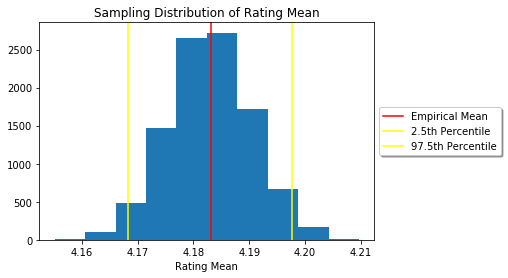

In [5]:
### A sampling distribution on customers' ratings using bootstrapping

# the empirical rating mean
rating_mean = df_stats['Rating'].mean()

# the bootstrapped replicates (rating mean) after 10000 simulation
bs_rating = stats.draw_bs_reps(df_stats['Rating'], np.mean, 10000)

# 95% confidence interval
conf_int = np.percentile(bs_rating, [2.5, 97.5])

# print the results
print('Empirical rating mean = {}'.format(rating_mean))
print('95% confidence interval = {}'.format(conf_int))

# plot
ptile_low = np.percentile(bs_rating, 2.5)
ptile_high = np.percentile(bs_rating, 97.5)
plt.hist(bs_rating)
plt.axvline(rating_mean, color='red', label='Empirical Mean')
plt.axvline(ptile_low, color='yellow', label='2.5th Percentile')
plt.axvline(ptile_high, color='yellow', label='97.5th Percentile')
plt.title('Sampling Distribution of Rating Mean')
plt.xlabel('Rating Mean')
plt.legend(loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           fancybox=True, 
           shadow=True)
plt.show()

In [6]:
# create a column that stores binary values based on rating
df_stats['Customer Satisfaction'] = np.where(df_stats.eval('Rating >= 4'), 1, 0)

# sanity check
df_stats.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Customer Satisfaction
11035,1093,53,Gorgeous but not flattering,Very pretty dress and nicely made (the embroid...,3,1,0,General,Dresses,Dresses,99,0
19170,1121,66,Hand wash?,"Darling jacket/coat, similar styling as the be...",2,0,0,General,Jackets,Outerwear,50,0
15745,945,23,Opted for larger size,I tried both the xs/s and the m/l and found th...,5,1,4,General,Tops,Sweaters,63,1
20983,895,48,"Cute, yellow is darker","This is a cute sweater, i agree that it's slig...",4,1,7,General Petite,Tops,Fine gauge,93,1
82,1133,33,Cute parka!,The rest of the reviewers are right about the ...,5,1,0,General,Jackets,Outerwear,93,1


In [7]:
# the number of satisfied and unsatisfied customers
df_stats['Customer Satisfaction'].value_counts()

1    17435
0     5193
Name: Customer Satisfaction, dtype: int64

In [8]:
# the proportion of satisfied customers
print(round(len(df_stats[df_stats['Customer Satisfaction'] == 1])/len(df_stats), 4))

0.7705


In [9]:
df_stats_satisfied = df_stats[df_stats['Customer Satisfaction'] == 1]

df_stats_satisfied_recommended = df_stats_satisfied['Recommended IND'].mean()

df_stats_unsatisfied = df_stats[df_stats['Customer Satisfaction'] == 0]

df_stats_unsatisfied_recommended = df_stats_unsatisfied['Recommended IND'].mean()

print('The recommended rate for satisfied customers is {}.'.format(round(df_stats_satisfied_recommended, 4)))
print('The recommended rate for unsatisfied customers is {}.'.format(round(df_stats_unsatisfied_recommended, 4)))

The recommended rate for satisfied customers is 0.9893.
The recommended rate for unsatisfied customers is 0.2463.


In [10]:
# emperical difference of recommended rate
empirical_diff_means = stats.diff_of_means(df_stats_satisfied['Recommended IND'], 
                                           df_stats_unsatisfied['Recommended IND'])

# draw 10,000 permutation replicates
perm_replicates = stats.draw_perm_reps(df_stats_satisfied['Recommended IND'], 
                                       df_stats_unsatisfied['Recommended IND'], 
                                       stats.diff_of_means, size=10000)

# compute p-value
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# print the result
print('p-value =', p)

p-value = 0.0


Empirical Recommended Rate Difference = 0.743


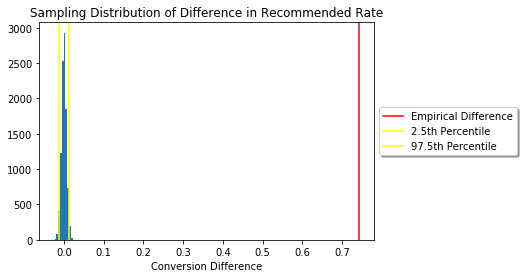

In [11]:
### A sampling distribution on the difference of recommended rate using permutation

# emperical difference of recommended rate
print('Empirical Recommended Rate Difference = {}'.format(round(empirical_diff_means, 4)))

# plot
ptile_low = np.percentile(perm_replicates, 2.5)
ptile_high = np.percentile(perm_replicates, 97.5)
plt.hist(perm_replicates)
plt.axvline(empirical_diff_means, color='red', label='Empirical Difference')
plt.axvline(ptile_low, color='yellow', label='2.5th Percentile')
plt.axvline(ptile_high, color='yellow', label='97.5th Percentile')
plt.title('Sampling Distribution of Difference in Recommended Rate')
plt.xlabel('Conversion Difference')
plt.legend(loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           fancybox=True, 
           shadow=True)
plt.show()

In [12]:
# a copy of the df_stats for building logistic model
df_stats_model = df_stats.copy()

# add an intercept for the model
df_stats_model = sm.add_constant(df_stats_model)

# sanity check
df_stats_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 13 columns):
const                      22628 non-null float64
Clothing ID                22628 non-null int64
Age                        22628 non-null int64
Title                      19662 non-null object
Review Text                22628 non-null object
Rating                     22628 non-null int64
Recommended IND            22628 non-null int64
Positive Feedback Count    22628 non-null int64
Division Name              22628 non-null object
Department Name            22628 non-null object
Class Name                 22628 non-null object
Word Count                 22628 non-null int64
Customer Satisfaction      22628 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.4+ MB


In [13]:
# a dummies list with one less category to achieve full rank matrix
dummies_list = sorted(df_stats['Department Name'].unique().tolist())[1:]

# sanity check
print(dummies_list)

['Dresses', 'Intimate', 'Jackets', 'Tops', 'Trend']


In [14]:
# create dummies columns
df_stats_model[dummies_list] = pd.get_dummies(df_stats_model['Department Name'])[dummies_list]

# sanity check
df_stats_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 18 columns):
const                      22628 non-null float64
Clothing ID                22628 non-null int64
Age                        22628 non-null int64
Title                      19662 non-null object
Review Text                22628 non-null object
Rating                     22628 non-null int64
Recommended IND            22628 non-null int64
Positive Feedback Count    22628 non-null int64
Division Name              22628 non-null object
Department Name            22628 non-null object
Class Name                 22628 non-null object
Word Count                 22628 non-null int64
Customer Satisfaction      22628 non-null int64
Dresses                    22628 non-null uint8
Intimate                   22628 non-null uint8
Jackets                    22628 non-null uint8
Tops                       22628 non-null uint8
Trend                      22628 non-null uint8
dtypes: float64(1), 

In [15]:
# instantiate a logistic model object
log_mod = sm.Logit(df_stats_model['Recommended IND'], 
                  df_stats_model[['const', 'Age', 'Positive Feedback Count',\
                                  'Word Count', 'Customer Satisfaction'] + dummies_list])

# fit the model
log_mod_results = log_mod.fit()

# model summary
log_mod_results.summary()

Optimization terminated successfully.
         Current function value: 0.173100
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Recommended IND   No. Observations:                22628
Model:                          Logit   Df Residuals:                    22618
Method:                           MLE   Df Model:                            9
Date:                Fri, 06 Jul 2018   Pseudo R-squ.:                  0.6342
Time:                        15:55:05   Log-Likelihood:                -3916.9
converged:                       True   LL-Null:                       -10709.
                                        LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.3542      0.149     -9.097      0.000      -1.646      -1.062
Age                         0.0055      0.002      2.224      0.026       0.001       0.010
Positive Feedback Count    -0.0191      0.005     -3.850      0.000      -0.029      -0.009
Word Count                  0.0032      0.001      2.963      0.003       0.001       0.005
Customer Satisfaction       5.6489      0.081     69.999      0.000       5.491       5.807
Dresses                    -0.1689      0.095     -1.786      0.074      -0.354       0.016
Intimate                   -0.0780      0.139     -0.563      0.574      -0.350       0.194
Jackets                    -0.3521      0.171     -2.060      0.039      -0.687      -0.017
Tops                       -0.1691      0.088     -1.915      0.055      -0.342       0.004
Trend                      -0.0425      0.350     -0.121      0.903      -0.729       0.644
===========================================================================================
"""

In [16]:
# odd ratios and corresponding confidence interval
stats_params = log_mod_results.params
conf_int = log_mod_results.conf_int()
conf_int['odd_ratios'] = stats_params
conf_int.columns = ['2.5%', '97.5%', 'odd_ratios']
print(np.exp(conf_int))

                               2.5%       97.5%  odd_ratios
const                      0.192829    0.345622    0.258159
Age                        1.000651    1.010376    1.005502
Positive Feedback Count    0.971633    0.990681    0.981111
Word Count                 1.001100    1.005410    1.003253
Customer Satisfaction    242.426274  332.630335  283.968894
Dresses                    0.701724    1.016576    0.844604
Intimate                   0.705020    1.213603    0.924994
Jackets                    0.502954    0.983117    0.703180
Tops                       0.710192    1.003961    0.844396
Trend                      0.482328    1.904406    0.958410


In [17]:
# import SIA from nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# instantiate a SIA object
SIA = SentimentIntensityAnalyzer()

# turn the column (Object) into String type
df_stats['Review Text'] = df_stats['Review Text'].astype(str)

# pair up new dataframe columns with SIA's scores
score_dict = dict(zip(['Polarity Score', 'Positive Score', 'Neutral Score', 'Negative Score'], 
                       ['compound', 'pos', 'neu', 'neg']))

# apply SIA function to the customers' reviews and generate scores
for key, value in score_dict.items():
    df_stats[key] = df_stats['Review Text'].apply(lambda x: SIA.polarity_scores(x)[value])

# populate the 'Sentiment' column based on 'Polarity Score'
df_stats['Sentiment'] = ''
df_stats.loc[df_stats['Polarity Score'] > 0,'Sentiment'] = 'Positive'
df_stats.loc[df_stats['Polarity Score'] == 0,'Sentiment'] = 'Neutral'
df_stats.loc[df_stats['Polarity Score'] < 0,'Sentiment'] = 'Negative'

# sanity check
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 17 columns):
Clothing ID                22628 non-null int64
Age                        22628 non-null int64
Title                      19662 non-null object
Review Text                22628 non-null object
Rating                     22628 non-null int64
Recommended IND            22628 non-null int64
Positive Feedback Count    22628 non-null int64
Division Name              22628 non-null object
Department Name            22628 non-null object
Class Name                 22628 non-null object
Word Count                 22628 non-null int64
Customer Satisfaction      22628 non-null int64
Polarity Score             22628 non-null float64
Positive Score             22628 non-null float64
Neutral Score              22628 non-null float64
Negative Score             22628 non-null float64
Sentiment                  22628 non-null object
dtypes: float64(4), int64(7), object(6)
memory usage: 3.1+ MB

In [18]:
# sanity check on sentiment type
df_stats.Sentiment.value_counts()

Positive    21053
Negative     1435
Neutral       140
Name: Sentiment, dtype: int64

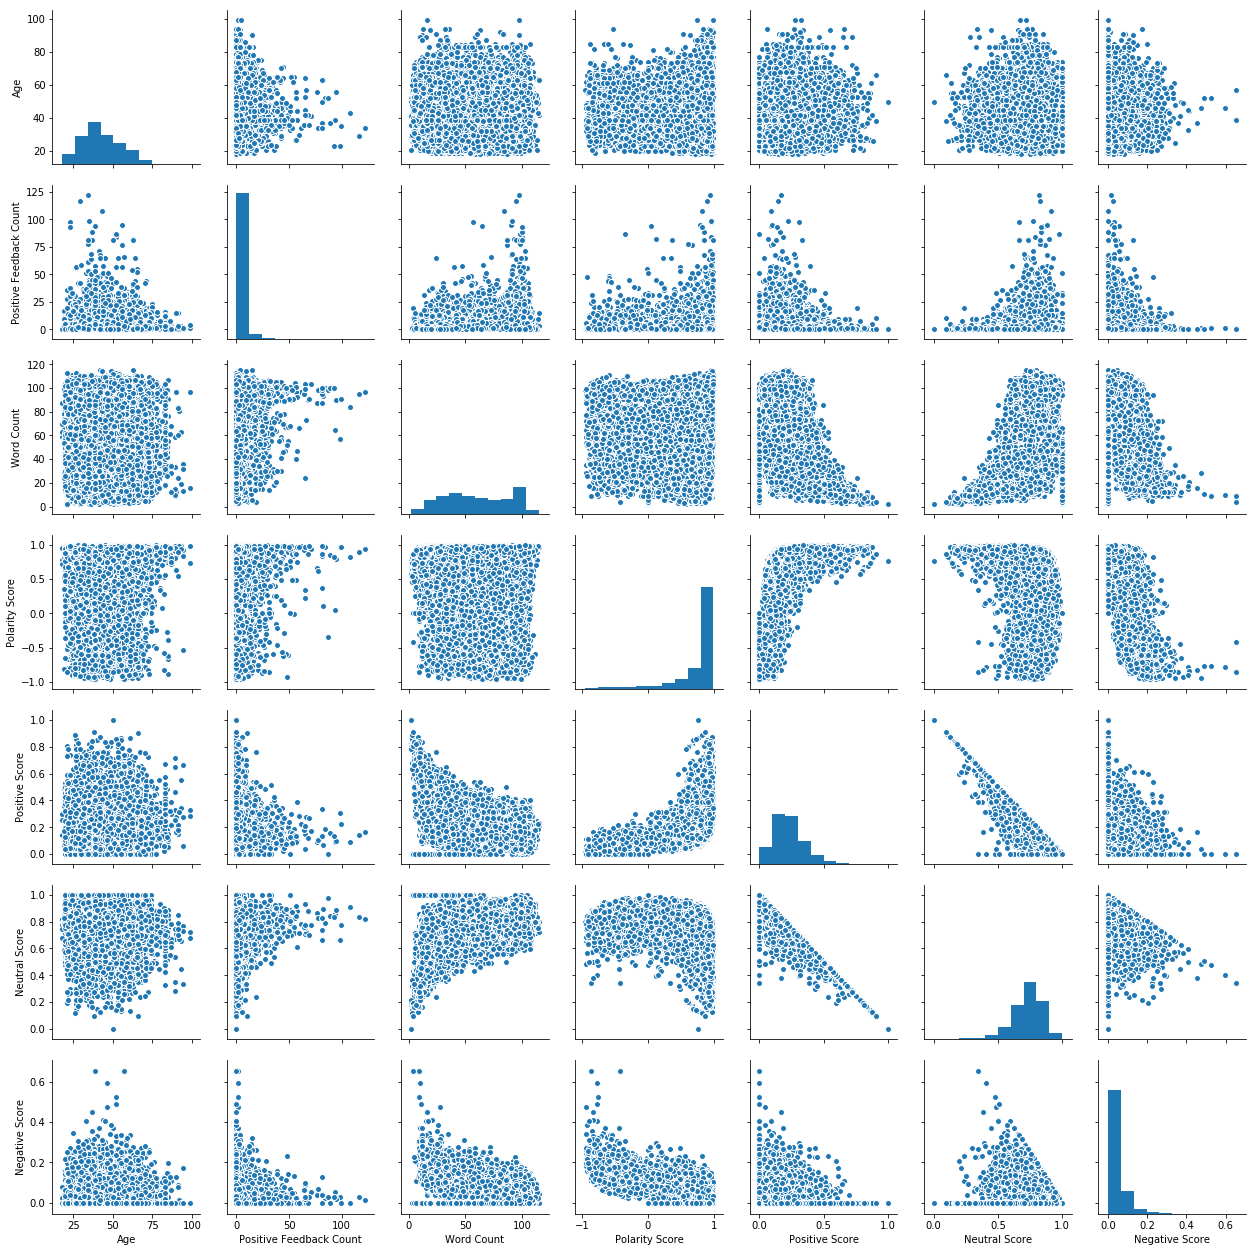

In [19]:
### A high level exploration on features from a bivariate perspective with pairplot

df_stats_pair = df_stats[['Age', 'Positive Feedback Count', 'Word Count', \
                          'Polarity Score', 'Positive Score', 'Neutral Score', 'Negative Score']]

sns.pairplot(data=df_stats_pair)
plt.show()

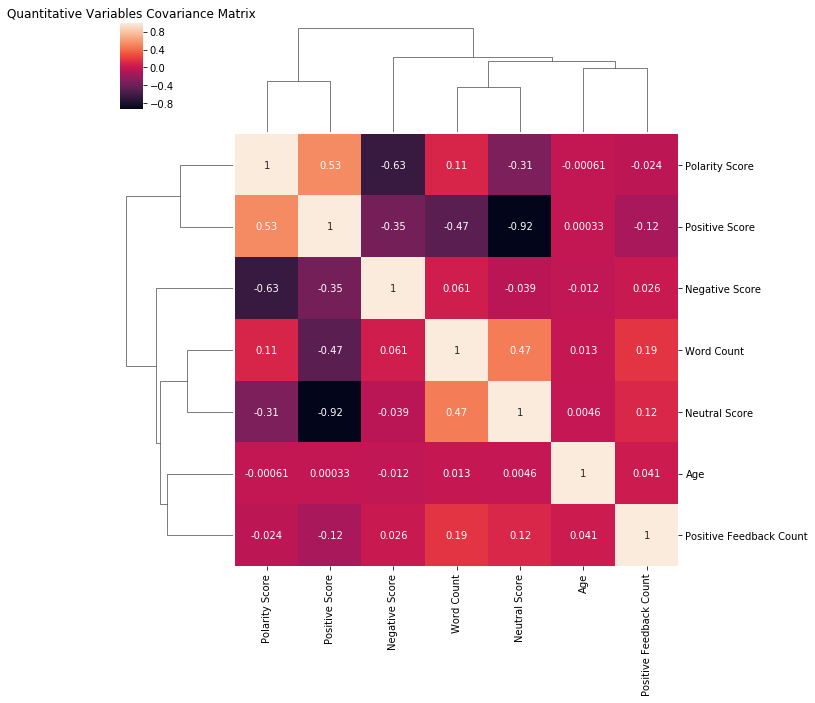

In [20]:
### A clustermap to visualize the hierarchical clustering on the covariance among quantitative variables

# get the Pearson Correlation of the quantitative variables
features_corr = df_stats_pair.corr('pearson')

# plot
fig = sns.clustermap(features_corr, row_cluster=True,
                     col_cluster=True,
                     annot=True,
                    figsize=(10,10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.title('Quantitative Variables Covariance Matrix')
plt.show()

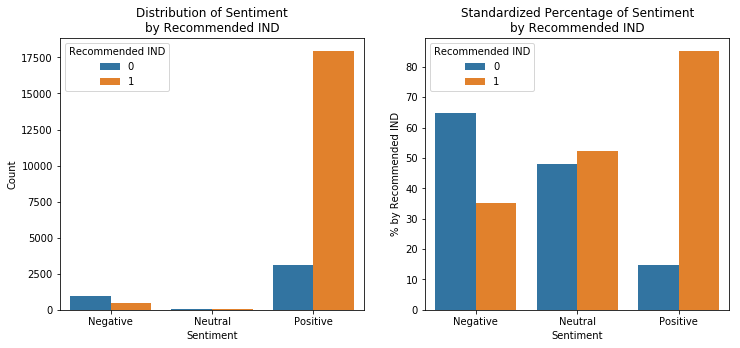

In [21]:
### A countplot on sentiment over recommended ind

# axis and hue
x = "Sentiment"
hue = "Recommended IND"

# plot
fig, axes = plt.subplots(1, 2, figsize=(12 ,5))
sns.countplot(x=x, hue=hue, data=df_stats, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Distribution of {}\nby {}".format(x, hue))
axes[0].set_ylabel("Count")
stats.pct_std_barplot(x=x, y="Percentage", hue=hue, data=df_stats, ax=axes[1])
axes[1].set_title("Standardized Percentage of {}\nby {}".format(x, hue))
axes[1].set_ylabel("% by {}".format(hue))
plt.show()

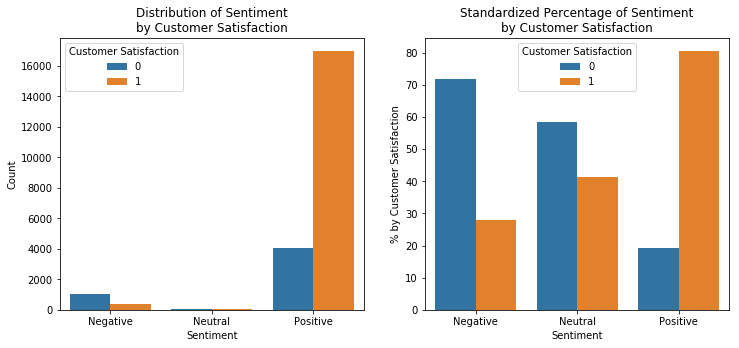

In [22]:
### A countplot on sentiment over customer satisfaction

# axis and hue
x = "Sentiment"
hue = "Customer Satisfaction"

# plot
fig, axes = plt.subplots(1, 2, figsize=(12 ,5))
sns.countplot(x=x, hue=hue, data=df_stats, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Distribution of {}\nby {}".format(x, hue))
axes[0].set_ylabel("Count")
stats.pct_std_barplot(x='Sentiment', y="Percentage", hue='Customer Satisfaction', data=df_stats, ax=axes[1])
axes[1].set_title("Standardized Percentage of {}\nby {}".format(x, hue))
axes[1].set_ylabel("% by {}".format(hue))
plt.show()

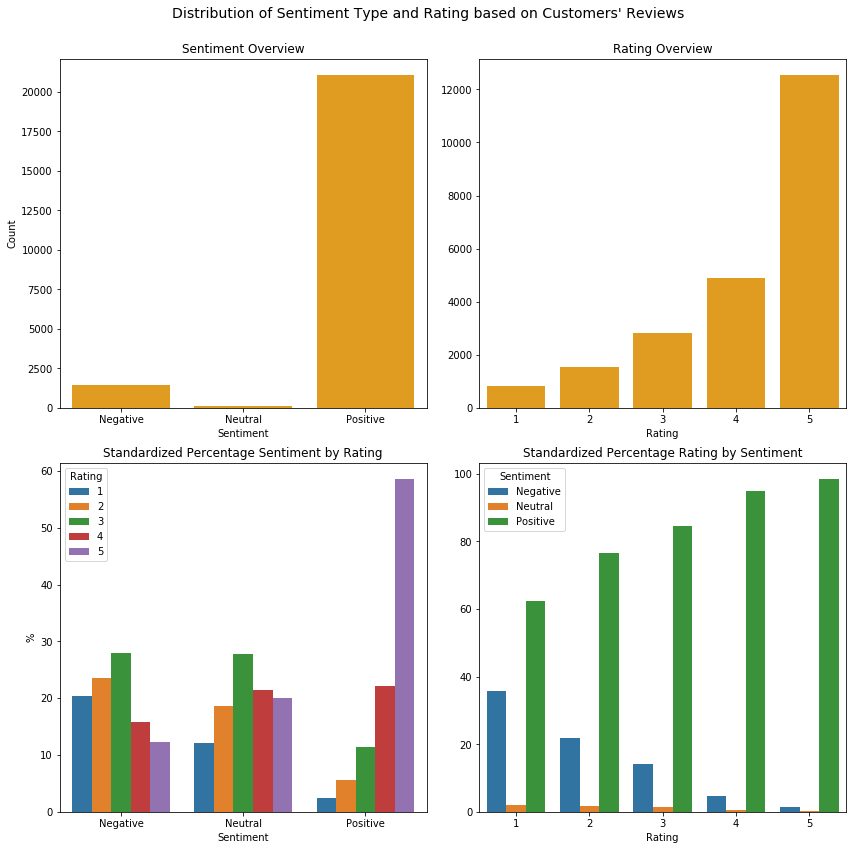

In [23]:
### Countplots and standardized percentage plots on sentiment and rating

# create subplots
fig, axes = plt.subplots(2, 2, figsize=[12,12])

# countplot on sentiment
sns.countplot(x='Sentiment', data=df_stats, ax=axes[0,0], 
              color='orange', order=['Negative', 'Neutral', 'Positive'])
axes[0,0].set_xlabel('Sentiment')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Sentiment Overview')

# countplot on rating
sns.countplot(x='Rating', data=df_stats, ax=axes[0,1], color='orange')
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('')
axes[0,1].set_title('Rating Overview')

# standardized percentage plot on sentiment over rating
stats.pct_std_barplot(x='Sentiment', y='Percentage', 
                      hue='Rating', data=df_stats, ax=axes[1,0])
axes[1,0].set_xlabel('Sentiment')
axes[1,0].set_ylabel('%')
axes[1,0].set_title('Standardized Percentage Sentiment by Rating')

# standardized percentage plot on rating over sentiment
stats.pct_std_barplot(x='Rating', y='Percentage', 
                      hue='Sentiment', data=df_stats, ax=axes[1,1])
axes[1,1].set_xlabel('Rating')
axes[1,1].set_ylabel('')
axes[1,1].set_title('Standardized Percentage Rating by Sentiment')

fig.suptitle("Distribution of Sentiment Type and Rating based on Customers' Reviews", fontsize=14) # title
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

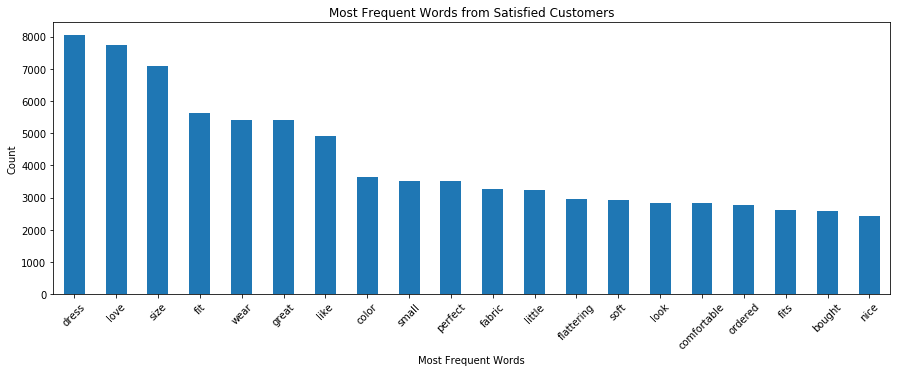

In [24]:
### Satisfied customers' reviews word count

# plot parameters
title = 'Most Frequent Words from Satisfied Customers' # title
reviews = df_stats['Review Text'][df_stats['Customer Satisfaction'] == 1] # satisfied customers' reviews

# plot
nlp.word_count(nlp.clean_reviews(reviews, concat=True), num_of_words=20).plot.bar(rot=45, legend=False, 
                                                                                  figsize=(15,5), title=title)
plt.ylabel('Count')
plt.xlabel('Most Frequent Words')
plt.show()

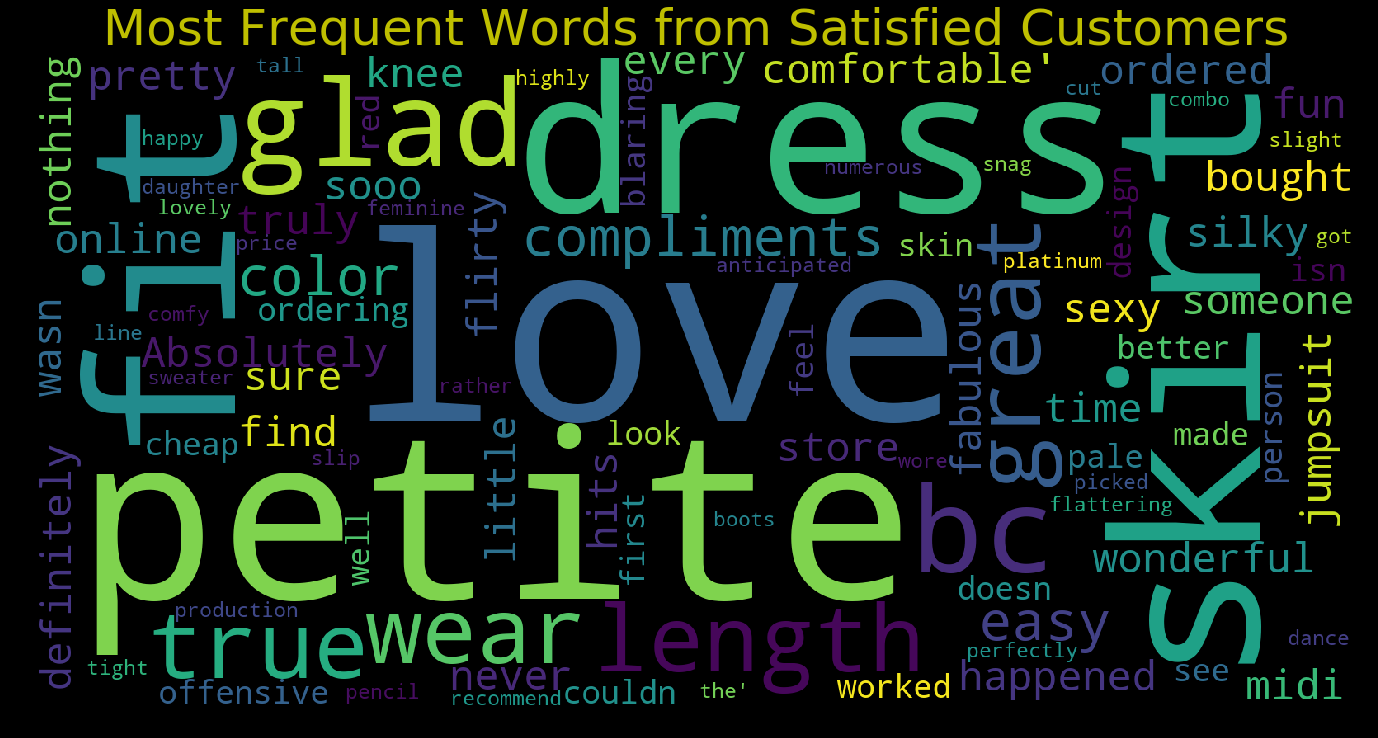

In [25]:
### Satisfied customers' reviews cloud

# plot wordcloud
nlp.wc_plot(reviews=reviews.values, title=title, stopwords=nlp.wc_stopwords)

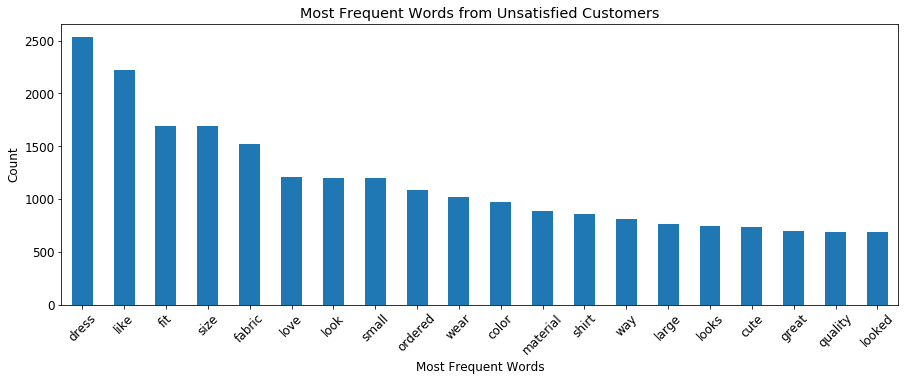

In [26]:
### Unsatisfied customers' reviews word count

# plot parameters
title = 'Most Frequent Words from Unsatisfied Customers' # title
reviews = df_stats['Review Text'][df_stats['Customer Satisfaction'] == 0] # unsatisfied customers' reviews

# plot
nlp.word_count(nlp.clean_reviews(reviews, concat=True), num_of_words=20).plot.bar(rot=45, legend=False,
                                                                                  figsize=(15,5), title=title)
plt.ylabel('Count')
plt.xlabel('Most Frequent Words')
plt.show()

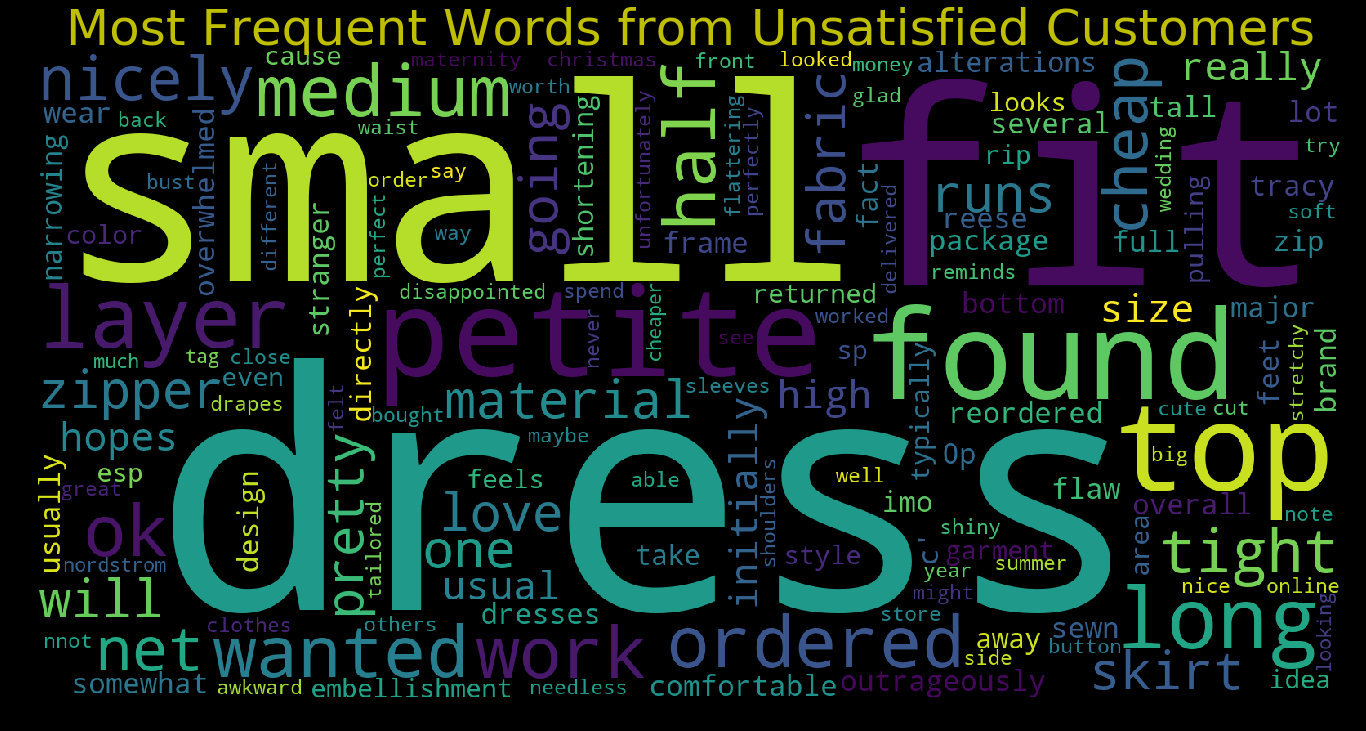

In [27]:
### Unsatisfied customers' reviews cloud

# plot wordcloud
nlp.wc_plot(reviews=reviews.values, title=title, stopwords=nlp.wc_stopwords)

In [28]:
# import Gensim packages
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

# preprocess customers' reviews
tokenized_reviews = nlp.clean_reviews(df_stats['Review Text'])

# create a Dictionary from the tokenized_reviews: dictionary
dictionary = Dictionary(tokenized_reviews)

# create a corpus
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

In [29]:
# import tools
from collections import defaultdict
import itertools

# create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count
    
# create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# print the top 20 words across all reviews alongside the count
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

dress 10567
love 8945
size 8770
fit 7322
like 7148
wear 6434
great 6114
fabric 4797
small 4726
color 4604
look 4039
ordered 3850
little 3773
perfect 3772
flattering 3519
soft 3336
comfortable 3058
cute 3042
nice 3023
bought 2986


In [30]:
# create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[corpus]

# create the defaultdict: weighted_words
weighted_words = defaultdict(float)
for word_id, weight in itertools.chain.from_iterable(tfidf_weights):
    weighted_words[word_id] = round(weight, 4)
    
# create a sorted list from the defaultdict: sorted_weighted_words
sorted_weighted_words = sorted(weighted_words.items(), key=lambda w: w[1], reverse=True)

# print the top 20 words across all reviews alongside the weights
for word_id, weights in sorted_weighted_words[:20]:
    print(dictionary.get(word_id), weights)

moo 0.903
librarian 0.8783
discontinued 0.8758
vas 0.8672
overdress 0.8665
exteemely 0.8615
granddaughter 0.8566
upgraded 0.8553
manu 0.8473
perches 0.8374
syle 0.82
deshn 0.8162
p6 0.815
safari 0.8146
honeymoon 0.8144
tule 0.8142
bonnet 0.8134
flatttering 0.8129
anrtho 0.8128
raincoat 0.8119


In [31]:
### A lookup table of ngrams phrases from satisfied customers

print("Satisfied Customers Top Phrases")
nlp.gram_lookup(reviews= df_stats['Review Text'][df_stats["Customer Satisfaction"].astype(int) == 1], 
           degree=[2,4,6,8,10], top_n=10)

Satisfied Customers Top Phrases


,2-Gram,Count,4-Gram,Count,6-Gram,Count,8-Gram,Count,10-Gram,Count
0,true size,1203,26 waist 36 hips,29,115 lbs 30 dd 26 waist,10,34b 26 waist 36 hips hem falls inches,3,lightweight soft cotton shorts think meant bea...,2
1,love dress,664,looks great skinny jeans,25,26 waist 36 hips hem falls,7,135 lbs 35 29 36 34d long torso,3,realize ordered like matches look photos short...,2
2,looks great,574,34b 26 waist 36,25,tall 145 lbs 38 32 40,7,wearing medium photos reference measurements 3...,3,outfit hot hot days loose elastic realize orde...,2
3,usually wear,555,love love love dress,23,34b 26 waist 36 hips hem,6,tall 145 lbs 38 36d 32 40 size,3,hot hot days loose elastic realize ordered lik...,2
4,fit perfectly,540,115 lbs 30 dd,21,5ft2in 34b 26 waist 36 hips,5,adorable comfortable 115 lbs ordered xs hits k...,2,hae prefered colors photo big deal guess order...,2
5,fits perfectly,480,dress fits true size,17,regular size small 34d 27 35,5,outfit hot hot days loose elastic realize ordered,2,hot days loose elastic realize ordered like ma...,2
6,size small,427,size small fits perfectly,16,36dd 10 12 tops 12 14,4,weight summer outfit hot hot days loose elastic,2,days loose elastic realize ordered like matche...,2
7,love love,415,lbs 30 dd 26,15,photos reference measurements 38 30 40,4,light weight summer outfit hot hot days loose,2,loose elastic realize ordered like matches loo...,2
8,love top,405,usually wear small medium,14,145 lbs 38 36d 32 40,4,thin light weight summer outfit hot hot days,2,elastic realize ordered like matches look phot...,2
9,usual size,393,great skinny jeans leggings,14,tall 145 lbs 38 36d 32,4,wearing thin light weight summer outfit hot hot,2,ordered like matches look photos shorts low cu...,2


In [32]:
### A lookup table of ngrams phrases from unsatisfied customers

# unsa
print("Unsatisfied Customers Top Phrases")
nlp.gram_lookup(reviews= df_stats['Review Text'][df_stats["Customer Satisfaction"].astype(int) == 0], 
           degree=[2,4,6,8,10], top_n=10)

Unsatisfied Customers Top Phrases


,2-Gram,Count,4-Gram,Count,6-Gram,Count,8-Gram,Count,10-Gram,Count
0,wanted love,276,measurements 38 30 40,9,photos reference measurements 38 30 40,3,wearing medium photos reference measurements 3...,3,sizes definitely small fit technically ill fit...,2
1,looked like,218,ordered usual size small,7,medium photos reference measurements 38 30,3,comments size wanted work ordered typically si...,2,franco dress retailer recent 20 sale looking d...,2
2,looks like,200,online ordered right away,6,wearing medium photos reference measurements 38,3,sizes definitely small fit technically ill fit...,2,size wanted work ordered typically size xs che...,2
3,going back,179,looked like maternity top,5,flattering top reference wearing medium photos,2,definitely small fit technically ill fitting d...,2,comments size wanted work ordered typically si...,2
4,look like,163,usually wear small medium,5,body type broad shoulders slim hips,2,small fit technically ill fitting dress short ...,2,reviewers comments size wanted work ordered ty...,2
5,true size,144,looked like maternity dress,4,usually wear size xs retailer tops,2,went shame color pictured wanted actual jeans ...,2,despite reviewers comments size wanted work or...,2
6,usually wear,140,better different body type,4,wear size xs retailer tops ordered,2,pairs went shame color pictured wanted actual ...,2,material instead thick heavy material unflatte...,2
7,felt like,139,reference measurements 38 30,4,top reference wearing medium photos measurements,2,review pairs went shame color pictured wanted ...,2,purchased eva franco dress retailer recent 20 ...,2
8,love dress,118,going back ordered size,4,wear month couple washes looks horrible,2,ordered review pairs went shame color pictured...,2,eva franco dress retailer recent 20 sale looki...,2
9,size small,113,usually wear medium large,4,week wear month couple washes looks,2,fit technically ill fitting dress short short ...,2,dress retailer recent 20 sale looking dresses ...,2


# Text Preprocessing, Model Building & Training

In [33]:
# import Gensim Word2Vec algorithm
from gensim.models import Word2Vec

# train model
w2v_model = Word2Vec(tokenized_reviews, min_count=1)

# summarize the loaded model
print(w2v_model)

# summarize vocabulary
words = list(w2v_model.wv.vocab)
print(words)

# save model
w2v_model.save('w2v_model.bin')

Word2Vec(vocab=13969, size=100, alpha=0.025)
['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable', 'love', 'dress', 'sooo', 'pretty', 'happened', 'store', 'glad', 'bc', 'ordered', 'online', 'petite', 'bought', 'length', 'hits', 'little', 'knee', 'definitely', 'true', 'midi', 'truly', 'high', 'hopes', 'wanted', 'work', 'initially', 'small', 'usual', 'size', 'outrageously', 'fact', 'zip', 'reordered', 'medium', 'ok', 'overall', 'half', 'fit', 'nicely', 'tight', 'layer', 'somewhat', 'cheap', 'net', 'layers', 'imo', 'major', 'design', 'flaw', 'sewn', 'directly', 'zipper', 'jumpsuit', 'fun', 'flirty', 'fabulous', 'time', 'wear', 'great', 'compliments', 'shirt', 'flattering', 'adjustable', 'tie', 'perfect', 'leggings', 'sleeveless', 'pairs', 'cardigan', 'tracy', 'reese', 'dresses', 'feet', 'tall', 'usually', '0p', 'brand', 'package', 'lot', 'skirt', 'long', 'overwhelmed', 'frame', 'stranger', 'alterations', 'shortening', 'narrowing', 'away', 'embellishment', 'garment', 'color', 'idea',

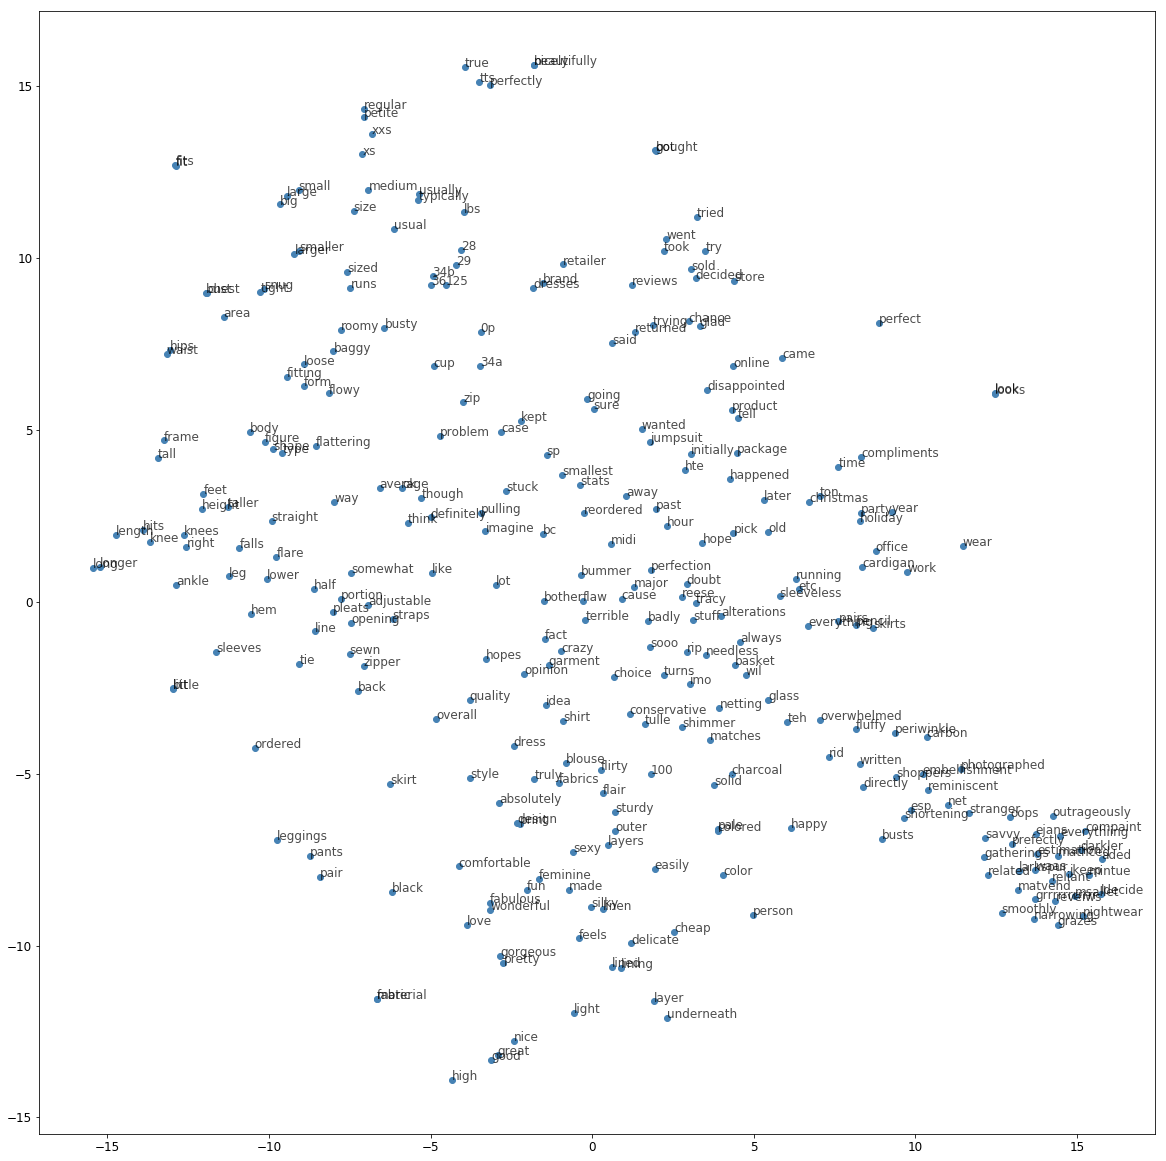

In [34]:
### Visualize high dimensional word vectors cluster

# import TSNE from sklearn
from sklearn.manifold import TSNE

# choose only the first 300 words
viz_words = 300

# fit a TSNE model to the vectors
X = w2v_model[w2v_model.wv.vocab]
tsne = TSNE()
embed_tsne = tsne.fit_transform(X[:viz_words, :])

# plot
fig, ax = plt.subplots(figsize=(20, 20))
for idx, word in enumerate(words[:viz_words]):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [35]:
# a copy of the original dataset for model building
df_nn = df.copy()

# drop NaN observations based on subsets
df_nn = df_nn.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'])

# create a column that stores binary values based on rating
df_nn['Customer Satisfaction'] = np.where(df_nn.eval('Rating >= 4'), 1, 0)

# turn the column (Object) into String type
df_nn['Review Text'] = df_nn['Review Text'].astype(str)

# apply SIA function to the customers' reviews and generate scores
for key, value in score_dict.items():
    df_nn[key] = df_nn['Review Text'].apply(lambda x: SIA.polarity_scores(x)[value])

# populate the 'Sentiment' column based on 'Polarity Score'
df_nn['Sentiment'] = ''
df_nn.loc[df_nn['Polarity Score'] > 0,'Sentiment'] = 'Positive'
df_nn.loc[df_nn['Polarity Score'] == 0,'Sentiment'] = 'Neutral'
df_nn.loc[df_nn['Polarity Score'] < 0,'Sentiment'] = 'Negative'

# Review Classification on Customer Satisfaction

In [36]:
# import functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical
from keras.models import load_model

# a threshold set for evaluating model performance (50% accuracy etc.)
threshold = 0.5

In [37]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(df_nn['Review Text'], df_nn['Customer Satisfaction'],
                                                    test_size=0.3, random_state=123)

# clean and tokenize train set
X_train = nlp.clean_reviews(X_train)

# create tokenizer
tokenizer = cnn.create_tokenizer(X_train)

# get the maximum review length
max_seq_length = cnn.max_length(X_train)

## Training (Customer Satisfaction)

In [38]:
# encode train set
X_train = cnn.encode_reviews(tokenizer, X_train, max_seq_length)
print(X_train.shape)

# model parameters
vocab_size = len(tokenizer.word_index) + 1
word_dict = tokenizer.word_index
embed_model='w2v_model.bin'
embedding_dim = 100
filter_sizes=[2,4,5] # ngrams
feature_maps=[150,150,150] # patterns
activation = 'sigmoid'
output_units = 1
dropout_rate = 0.5
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model_image = 'multichannel_binary.png'

# instantiate model
model = cnn.build_cnn(embed_model='w2v_model.bin', num_of_words=vocab_size, word_dict=word_dict,
                      embedding_dim=embedding_dim, filter_sizes=filter_sizes,
                      feature_maps=feature_maps, max_seq_length=max_seq_length,
                      activation=activation, output_units=output_units,
                      dropout_rate=dropout_rate, loss=loss,
                      optimizer=optimizer, metrics=metrics, model_image=model_image)

# fit model (With validation)
model.fit([X_train], np.array(y_train), validation_split=0.33, epochs=10, batch_size=75)

# save the model
model.save('binary_model_customer_satisfaction.h5')

(15839, 58)
Creating CNN ...
****************
Embedding: using pretrained embedding
Vocabulary size: 11935
Embedding dim: 100
Filter sizes: [2, 4, 5]
Feature maps: [150, 150, 150]
Max sequence: 58
****************
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 58, 100)      1193500     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 58, 100)      0           embedding_1[0][0]                
_____________________________________________________________________________________________

## Testing (Customer Satisfaction)

In [39]:
# clean and tokenize test set
X_test = nlp.clean_reviews(X_test)

# encode test set
X_test = cnn.encode_reviews(tokenizer, X_test, max_seq_length)
print(X_train.shape, X_test.shape)
 
# load the model
model = load_model('binary_model_customer_satisfaction.h5')

# predictions
preds = model.predict([X_test])

# model evaluation
print(accuracy_score(y_test, preds>threshold)) # accuracy
print('\n')
print(confusion_matrix(y_test, preds>threshold)) # confusion matrix
print('\n')
print(classification_report(y_test, preds>threshold, target_names=['Unsatisfied', 'Satisfied'])) # a summary on all metrics

(15839, 58) (6789, 58)
0.8712623361319782


[[ 855  624]
 [ 250 5060]]


             precision    recall  f1-score   support

Unsatisfied       0.77      0.58      0.66      1479
  Satisfied       0.89      0.95      0.92      5310

avg / total       0.86      0.87      0.86      6789



# Review Classification on Recommended IND

In [40]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_nn['Review Text'], df_nn['Recommended IND'],
                                                    test_size=0.3, random_state=123)

# clean and tokenize train set
X_train = nlp.clean_reviews(X_train)

# create tokenizer
tokenizer = cnn.create_tokenizer(X_train)

# get the maximum review length
max_seq_length = cnn.max_length(X_train)

## Training (Recommended IND)

In [41]:
# encode train set
X_train = cnn.encode_reviews(tokenizer, X_train, max_seq_length)
print(X_train.shape)

# model parameters
vocab_size = len(tokenizer.word_index) + 1
word_dict = tokenizer.word_index
embed_model='w2v_model.bin'
embedding_dim = 100
filter_sizes=[2,4,5]
feature_maps=[150,150,150]
activation = 'sigmoid'
output_units = 1
dropout_rate = 0.5
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model_image = 'multichannel_binary.png'
 
# instantiate model
model = cnn.build_cnn(embed_model='w2v_model.bin', num_of_words=vocab_size, word_dict=word_dict,
                      embedding_dim=embedding_dim, filter_sizes=filter_sizes,
                      feature_maps=feature_maps, max_seq_length=max_seq_length,
                      activation=activation, output_units=output_units,
                      dropout_rate=dropout_rate, loss=loss,
                      optimizer=optimizer, metrics=metrics, model_image=model_image)

# fit model (With validation)
model.fit([X_train], np.array(y_train), validation_split=0.33, epochs=10, batch_size=75)

# save the model
model.save('binary_model_recommended_ind.h5')

(15839, 58)
Creating CNN ...
****************
Embedding: using pretrained embedding
Vocabulary size: 11935
Embedding dim: 100
Filter sizes: [2, 4, 5]
Feature maps: [150, 150, 150]
Max sequence: 58
****************
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 58, 100)      1193500     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 58, 100)      0           embedding_2[0][0]                
_____________________________________________________________________________________________

## Testing (Recommended IND)

In [42]:
# clean and tokenize test set
X_test = nlp.clean_reviews(X_test)

# encode test set
X_test = cnn.encode_reviews(tokenizer, X_test, max_seq_length)
print(X_train.shape, X_test.shape)
 
# load the model
model = load_model('binary_model_recommended_ind.h5')

# predictions
preds = model.predict([X_test])

# model evaluation
print(accuracy_score(y_test, preds>threshold)) # accuracy
print('\n')
print(confusion_matrix(y_test, preds>threshold)) # confusion matrix
print('\n')
print(classification_report(y_test, preds>threshold, target_names=['Not Recommended', 'Recommended'])) # a summary on all metrics

(15839, 58) (6789, 58)
0.8915893356900869


[[ 609  558]
 [ 178 5444]]


                 precision    recall  f1-score   support

Not Recommended       0.77      0.52      0.62      1167
    Recommended       0.91      0.97      0.94      5622

    avg / total       0.88      0.89      0.88      6789



# Review Classification on Sentiments

In [43]:
### Numerically encoding and categorization for sentiment types

# get the sentiment types
sentiment_types = df_nn['Sentiment'].unique()

# initialize a dictionary
target_names = {}

# enumerate sentiment types with indices as the values
for i, sentiment_type in enumerate(sentiment_types):
    target_names[sentiment_type] = i

# apply dictionary to sentiments
labels = df_nn['Sentiment'].apply(lambda x: target_names[x])

# categorize extracted labels
labels = to_categorical(np.asarray(labels[df_nn.index]))

In [44]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_nn['Review Text'], labels,
                                                    test_size=0.3, random_state=123)

# clean and tokenize train set
X_train = nlp.clean_reviews(X_train)

# create tokenizer
tokenizer = cnn.create_tokenizer(X_train)

# get the maximum review length
max_seq_length = cnn.max_length(X_train)

## Training (Sentiments)

In [45]:
# encode train set
X_train = cnn.encode_reviews(tokenizer, X_train, max_seq_length)
print(X_train.shape)

# model parameters
vocab_size = len(tokenizer.word_index) + 1
word_dict = tokenizer.word_index
embed_model='w2v_model.bin'
embedding_dim = 100
filter_sizes=[2,4,5]
feature_maps=[150,150,150]
activation = 'softmax'
output_units = 3
dropout_rate = 0.5
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model_image = 'multichannel_multiclass.png'
 
# instantiate model
model = cnn.build_cnn(embed_model='w2v_model.bin', num_of_words=vocab_size, word_dict=word_dict,
                      embedding_dim=embedding_dim, filter_sizes=filter_sizes,
                      feature_maps=feature_maps, max_seq_length=max_seq_length,
                      activation=activation, output_units=output_units,
                      dropout_rate=dropout_rate, loss=loss,
                      optimizer=optimizer, metrics=metrics, model_image=model_image)

# fit model (With validation)
model.fit([X_train], np.array(y_train), validation_split=0.33, epochs=10, batch_size=75)

# save the model
model.save('multiclass_model_sentiments.h5')

(15839, 58)
Creating CNN ...
****************
Embedding: using pretrained embedding
Vocabulary size: 11935
Embedding dim: 100
Filter sizes: [2, 4, 5]
Feature maps: [150, 150, 150]
Max sequence: 58
****************
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 58, 100)      1193500     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 58, 100)      0           embedding_3[0][0]                
_____________________________________________________________________________________________

## Testing (Sentiments)

In [46]:
# clean and tokenize test set
X_test = nlp.clean_reviews(X_test)

# encode test set
X_test = cnn.encode_reviews(tokenizer, X_test, max_seq_length)
print(X_train.shape, X_test.shape)
 
# load the model
model = load_model('multiclass_model_sentiments.h5')

# predictions
preds = model.predict([X_test])

# model evaluation
print(accuracy_score(y_test, preds>threshold)) # accuracy
print('\n')
print(classification_report(y_test, preds>threshold, target_names=target_names.keys())) # a summary on all metrics

(15839, 58) (6789, 58)
0.9297392841361025


             precision    recall  f1-score   support

   Positive       0.94      0.99      0.97      6315
   Negative       0.69      0.07      0.12       436
    Neutral       0.00      0.00      0.00        38

avg / total       0.92      0.93      0.91      6789



# Review Classification on Sentiments (Without pre-trained embedding)

## Training (Sentiments without pre-trained embedding)

In [47]:
# instantiate model
model = cnn.build_cnn(embed_model=None, num_of_words=vocab_size, word_dict=word_dict,
                      embedding_dim=embedding_dim, filter_sizes=filter_sizes,
                      feature_maps=feature_maps, max_seq_length=max_seq_length,
                      activation=activation, output_units=output_units,
                      dropout_rate=dropout_rate, loss=loss,
                      optimizer=optimizer, metrics=metrics, model_image=model_image)

# fit model (With validation)
model.fit([X_train], np.array(y_train), validation_split=0.33, epochs=10, batch_size=75)

# save the model
model.save('multiclass_model_sentiments_without_pretrained.h5')

Creating CNN ...
****************
Embedding: no pretrained embedding
Vocabulary size: 11935
Embedding dim: 100
Filter sizes: [2, 4, 5]
Feature maps: [150, 150, 150]
Max sequence: 58
****************
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 58, 100)      1193500     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 58, 100)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_10

## Testing (Sentiments without pre-trained embedding)

In [48]:
# dataset shapes
print(X_train.shape, X_test.shape)

# load the model
model = load_model('multiclass_model_sentiments_without_pretrained.h5')

# predictions
preds = model.predict([X_test])

# model evaluation
print(accuracy_score(y_test, preds>threshold)) # accuracy
print('\n')
print(classification_report(y_test, preds>threshold, target_names=target_names.keys())) # a summary on all metrics

(15839, 58) (6789, 58)
0.9206068640447783


             precision    recall  f1-score   support

   Positive       0.95      0.97      0.96      6315
   Negative       0.38      0.25      0.30       436
    Neutral       0.00      0.00      0.00        38

avg / total       0.90      0.92      0.91      6789

